In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,IPython, librosa, mir_eval
from sys import platform
from os import listdir
from os.path import isfile, join,isdir
from IPython.display import Audio
from librosa.display import waveplot,specshow
from librosa.onset import onset_strength, onset_detect
from librosa.feature import melspectrogram, mfcc
from librosa import load

from collections import defaultdict,OrderedDict
import sklearn
from sklearn.preprocessing import StandardScaler,LabelEncoder
import scipy
from pandas import HDFStore,DataFrame



# Song Extraction from fma_small

1. Find the song folder path relative to the current computer
2. Retrieve the different genre classifications
3. Identify each song via its full path to song using index, to guarantee one-to-one mapping 
4. Sort in alphabetical order

In [2]:
#retrieving path to the fma_small directory and the corresponding meta data
HOME_DIR = IPython.utils.path.get_home_dir()

temp = join(HOME_DIR, 'Documents')
path_to_small_fma = join(temp, 'fma_small')
json_file = join(path_to_small_fma,'fma_small.json')
#locate meta_dta
print(path_to_small_fma)
df = pd.read_json(json_file)
print(json_file)


/Users/chibmac/Documents/fma_small
/Users/chibmac/Documents/fma_small/fma_small.json


In [3]:
#only choose top genre as the label
df = df.loc[:,['top_genre','train']]

#ensure that the genre name matches file name in fma_small, 
#i.e Oldtime / Historian conflict issue
df['top_genre']=df['top_genre'].apply(lambda y: y.split(os.sep)[0].strip())
#locate each individual song by its full path
df['temp'] = path_to_small_fma
str_index = ["%.2d" % x for x in df.index]
complete_genre_list = df['top_genre'].unique()

#create full path to file and store as a single array
df['full_path_to_song'] = df.temp.map(str)+ "/"+ df['top_genre'].values+ "/"+ str_index+ ".mp3"
del df['temp']
#keep songs according to alphabetical order of songs 
df.sort_values(by = 'top_genre', inplace = True)
df.head()


,top_genre,train,full_path_to_song
100538,Electronic,True,/Users/chibmac/Documents/fma_small/Electronic/...
43206,Electronic,True,/Users/chibmac/Documents/fma_small/Electronic/...
43199,Electronic,True,/Users/chibmac/Documents/fma_small/Electronic/...
43153,Electronic,True,/Users/chibmac/Documents/fma_small/Electronic/...
43124,Electronic,True,/Users/chibmac/Documents/fma_small/Electronic/...


In [4]:
complete_genre_list_df = pd.DataFrame(complete_genre_list, columns = ['Genre'])
complete_genre_list_df

,Genre
0,Electronic
1,Rock
2,Old-Time
3,Indie-Rock
4,Jazz
5,Folk
6,Pop
7,Psych-Rock
8,Punk
9,Hip-Hop


In [5]:
#retrieve number of songs per genre
genre_and_count = df['top_genre'].value_counts().sort_index()
all_songs_path = df['full_path_to_song'].values  
print(genre_and_count)

Electronic    400
Folk          400
Hip-Hop       400
Indie-Rock    400
Jazz          400
Old-Time      400
Pop           400
Psych-Rock    400
Punk          400
Rock          400
Name: top_genre, dtype: int64


In [6]:
song_counts = [] 
ordered_genres = [] 
full_song_df = OrderedDict()
genre_to_song_dict = {}


#retrieve number of songs per genre with the order preserved in two lists
#ordered_genres
#song_counts
for i,genre in enumerate(genre_and_count.index):
    ordered_genres.append(genre)
    temp = df['top_genre'].value_counts()[genre]
    song_counts.append(temp)

genre_to_song_zipped = zip(ordered_genres,song_counts)

num_of_genre = np.shape(genre_and_count)[0]
print("The number of genres is:", num_of_genre)

#dictionary with each song count and its corresponding genre
for genre,song_count in genre_to_song_zipped:
    genre_to_song_dict[genre] = song_count

genre_to_song_dict

The number of genres is: 10


{'Electronic': 400,
 'Folk': 400,
 'Hip-Hop': 400,
 'Indie-Rock': 400,
 'Jazz': 400,
 'Old-Time': 400,
 'Pop': 400,
 'Psych-Rock': 400,
 'Punk': 400,
 'Rock': 400}

In [7]:
num_of_genre = np.shape(genre_and_count)[0]
all_songs_path = df['full_path_to_song'].values

paths_dict = OrderedDict()

#prepend zero so we have a start point for all_songs_path 
#and avoid messing with indices

#use the cumulative sum to find none uniform ranges
song_counts.insert(0,0)
cumulative_sum = np.cumsum(song_counts,dtype=int)

#creates a dictionary of the genres and its corresponding path
for i,genre in enumerate(ordered_genres):
    str1=genre
    str2 = "_paths"
    genre_paths = "".join((str1,str2))
    paths_dict[genre_paths] = all_songs_path[cumulative_sum[i]:cumulative_sum[i+1]]

#paths_dict
#{genre_path_name: genre_paths}
print("{'Electronic_paths:[array_of_all_electronic_paths]}")

{'Electronic_paths:[array_of_all_electronic_paths]}


In [8]:
%%time
num_of_songs = 3
sampling_rate = 44100

genre_signals_dict = OrderedDict()
#creates a dictionary of the signals in a genre and their raw file
for genre_path_name,genre_paths in paths_dict.items():
    str1=genre_path_name[:-5]
    str2 = "signals"
    genre_signals = "".join((str1,str2))       
    try:
        first_three = genre_paths[:num_of_songs]
        genre_signals_dict[genre_signals] = [
        load(p,sr=sampling_rate)[0] for p in first_three]
    except IOError as exc:
        print("Unable to locate folder")
        #raise IOError("%s: %s" % (genre_paths, exc.strerror))
        
#genre_signals_dict
#{genre_signals_name:genre_signals_paths}
print("{'Electronic_signals:[array_of_all_electronic_paths]}")

{'Electronic_signals:[array_of_all_electronic_paths]}
CPU times: user 10.9 s, sys: 445 ms, total: 11.3 s
Wall time: 11.3 s


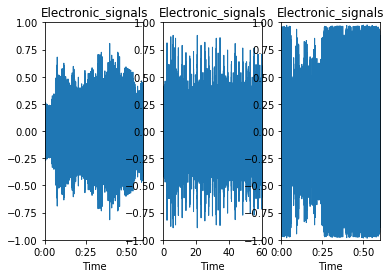

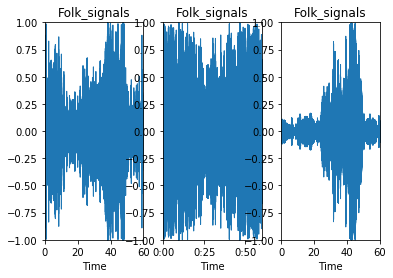

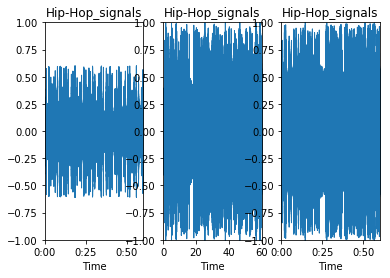

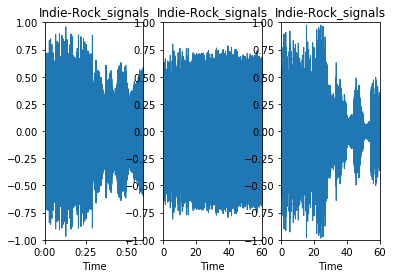

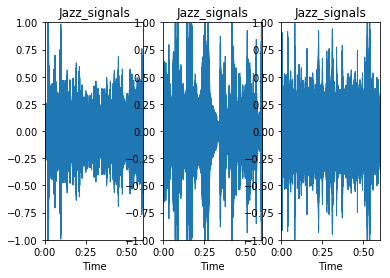

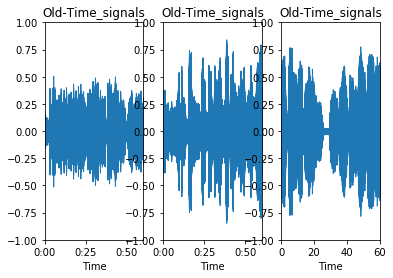

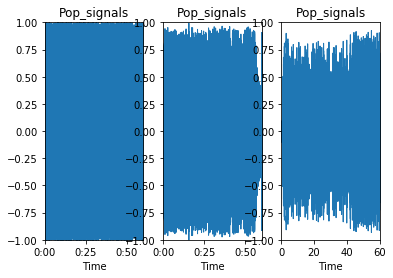

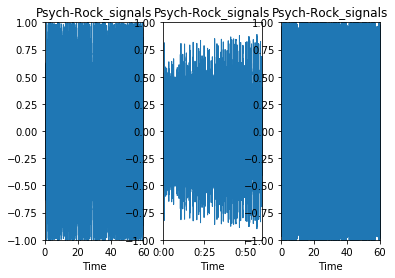

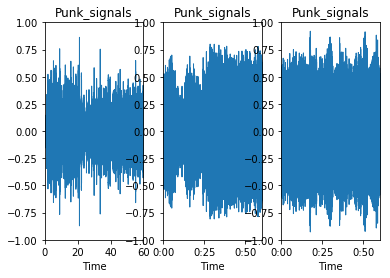

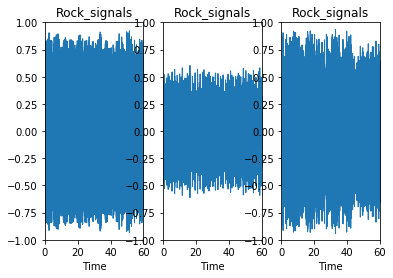

In [9]:
#plot the time series for each song according to the genres

#sig_lengths = []
for genre_signal_name,genre_signals in genre_signals_dict.items(): 
    for i, sig_amp in enumerate(genre_signals):
        plt.subplot(1, num_of_songs, i+1)
#        sig_lengths.append(len(sig_amp))
        waveplot(sig_amp)
        plt.ylim(-1, 1)
        plt.title(genre_signal_name)
    plt.figure()
        
    

## Testing the complete feature extraction on a single song

In [10]:
pwd

'/Users/chibmac/Documents/FinalSemesterProject/fma-baselines'

In [11]:
#home laptop
if "Ubuntu" in os.uname().version:
    song, sampling_rate = librosa.load("/home/chib/Documents/fma_small/Electronic/99289.mp3")

#lab macbook
elif "Darwin" in os.uname().version:
    song, sampling_rate = librosa.load("/Users/chibmac/Documents/fma_small/Electronic/99289.mp3")

else: 
    song, sampling_rate = librosa.load(librosa.util.example_audio_file())
    
song.shape


(661248,)

In [12]:
short_song_length = 1322496
#short_song_length = int(min_song_length/2)
short_song_length = short_song_length-(short_song_length%2048)
short_song_length

1320960

In [13]:
num_of_frames = int(short_song_length/2048)
#number of frames to nearest 10 
num_of_frames = num_of_frames-(num_of_frames%10)
num_of_frames

640

In [14]:
#the number of frames will always be a factor of 2048 and in addition 5,10 since it ends is rounded to nearest 10
segments_list = [1,2,4,5,8,10]
num_of_segments = segments_list[-1]
num_of_segments

10

In [15]:
num_of_frames_per_segment = int(num_of_frames/num_of_segments)
num_of_frames_per_segment

64

In [16]:
shortest_song_length = num_of_frames *2048
shortest_song_length

1310720

In [17]:
num_of_mfcc = 12

In [18]:
int(np.floor((shortest_song_length*4)/2048))

2560

In [19]:
num_of_subframes = int(np.floor((shortest_song_length*4)/2048))
#num_of_frames = num_of_frames-(num_of_frames%10)
num_of_subframes_per_segment = int(num_of_subframes/num_of_segments)
num_of_subframes_per_segment

256

#should be a factor of the number of frames
factor_list = []
for i in range(1,10):
    if (num_of_frames%i == 0) :
        factor_list.append(i)
num_of_segments = factor_list[-1]
print("Number of segments: %d"% num_of_segments)
factor_list

#2048 is default for n_fft
#4 as hopsize is 2048/4
song_length = int(num_of_frames*2048/4 - (num_of_frames*2048/4 %10))
song_length

In [34]:
song_f = song[:shortest_song_length -1] 
song_t = song[:shortest_song_length] 
ind_song_into_segment = int(len(song_t)/num_of_segments)



In [35]:
ind_song_into_segment

66124

In [36]:
song_t.shape

(661248,)

In [37]:
num_of_segments

10

In [38]:
song_into_segments = np.reshape(song_t,(num_of_segments,ind_song_into_segment))
song_into_segments.shape

ValueError: total size of new array must be unchanged

# Time Domain Features
- 
## Zero Crossing Rate (ZCR) 
- 
## Onsets 


In [ ]:
zcr_features_per_segment = np.sum(librosa.core.zero_crossings(song_into_segments),axis = 1) #zero crossings returns boolean values
zcr_features_per_segment = np.reshape(zcr_features_per_segment,(zcr_features_per_segment.shape[0],1))
for i in range (num_of_segments):
    print("Segment number %d: has %d zero crossings"%(i+1,zcr_features_per_segment[i]))

zcr_features_per_segment.shape

In [ ]:
onset_frames = librosa.onset.onset_detect(y=song_t, sr=sampling_rate, units='samples')
onset_length = len(onset_frames)
onset_frames

In [ ]:
song_splitter = np.arange(0,len(song_t)+1, ind_song_into_segment,dtype=int)
split_length = len(song_splitter)
song_splitter

In [ ]:
total_onsets = [0]
for i in range(1,len(song_splitter)):
    total_onsets.append(np.sum(onset_frames<song_splitter[i]))

total_onsets

In [ ]:
total_onset_diff = np.diff(total_onsets)
onsets_features_per_segment = np.reshape(total_onset_diff,(len(total_onset_diff),1))
for i in range (num_of_segments):
    print("Segment number %d: has %d onsets"%(i+1,onsets_features_per_segment[i]))

onsets_features_per_segment.shape

In [ ]:
time_domain_features = np.concatenate((zcr_features_per_segment,onsets_features_per_segment),axis =1)
time_domain_features

# Frequency Domain Features
- 
## MFCC 
- 
## Spectral Centroid



In [ ]:
mfcc_per_segment = librosa.feature.mfcc(y=song_f, sr=sampling_rate,
                                     n_mfcc=num_of_mfcc).T

mfcc_per_segment.shape

In [ ]:
num_of_frames_per_segment

In [ ]:
num_of_mfcc

In [ ]:
num_of_segments

In [ ]:
mfcc_per_segment = librosa.feature.mfcc(y=song_f, sr=sampling_rate,
                                     n_mfcc=num_of_mfcc).T
print("The number of frames is %d" % mfcc_per_segment.shape[0])

In [ ]:
mfcc_per_segment.shape

In [ ]:
mfcc_per_segment = librosa.feature.mfcc(y=song_f, sr=sampling_rate,
                                     n_mfcc=num_of_mfcc).T
print("The number of frames is %d" % mfcc_per_segment.shape[0])
mfcc_per_segment = np.reshape(mfcc_per_segment,(num_of_segments,num_of_subframes_per_segment,num_of_mfcc))
mps_seg,mps_fps,mps_mfccs = mfcc_per_segment.shape

print("Number of Segments: %d, Number of subframes per segment: %d, Number of mfccs:%d" %(mps_seg,mps_fps, mps_mfccs))  

mfcc_per_segment.shape


In [ ]:
mean_mfcc_per_segment = np.mean(mfcc_per_segment,axis=1)
#mean_mfcc_per_segment = np.reshape(mean_mfcc_per_segment,(mean_mfcc_per_segment.shape[0],1,mean_mfcc_per_segment.shape[1]))
var_mfcc_per_segment = np.var(mfcc_per_segment,axis =1)
#var_mfcc_per_segment = np.reshape(var_mfcc_per_segment,(var_mfcc_per_segment.shape[0],1,var_mfcc_per_segment.shape[1]))
skew_mfcc_per_segment = scipy.stats.skew(mfcc_per_segment,axis =1)
#skew_mfcc_per_segment = np.reshape(skew_mfcc_per_segment,(skew_mfcc_per_segment.shape[0],1,skew_mfcc_per_segment.shape[1]))
kurtosis_mfcc_per_segment = scipy.stats.kurtosis(mfcc_per_segment,axis =1)
#kurtosis_mfcc_per_segment = np.reshape(kurtosis_mfcc_per_segment,(kurtosis_mfcc_per_segment.shape[0],1,kurtosis_mfcc_per_segment.shape[1]))


In [ ]:
mfcc_features_per_segment = np.concatenate((mean_mfcc_per_segment,var_mfcc_per_segment,skew_mfcc_per_segment,kurtosis_mfcc_per_segment),axis = 1)

mfcc_features_per_segment.shape

In [ ]:
spectral_centroid = librosa.feature.spectral_centroid(y=song_f, sr=sampling_rate).T
print(spectral_centroid.shape)
spc_per_segment = np.reshape(spectral_centroid, (num_of_segments,num_of_subframes_per_segment))
spc_per_segment.shape
#mean_spc_per_segment.shape

In [ ]:
mean_spc_per_segment = np.mean(spc_per_segment,axis=1)
mean_spc_per_segment = np.reshape(mean_spc_per_segment,(len(mean_spc_per_segment),1))
var_spc_per_segment = np.var(spc_per_segment,axis =1)
var_spc_per_segment = np.reshape(var_spc_per_segment,(len(var_spc_per_segment),1))
skew_spc_per_segment = scipy.stats.skew(spc_per_segment,axis =1)
skew_spc_per_segment = np.reshape(skew_spc_per_segment,(len(skew_spc_per_segment),1))
kurtosis_spc_per_segment = scipy.stats.kurtosis(spc_per_segment,axis =1)
kurtosis_spc_per_segment = np.reshape(kurtosis_spc_per_segment,(len(kurtosis_spc_per_segment),1))

mean_spc_per_segment.shape

In [ ]:
spc_features_per_segment = np.concatenate((mean_spc_per_segment,var_spc_per_segment,skew_spc_per_segment,kurtosis_spc_per_segment),axis = 1)

#spc_x,spc_y = spc_features_per_segment.shape

#spc_features_per_segment = np.reshape(spc_features_per_segment,(spc_x,spc_y,1))
spc_features_per_segment.shape

In [ ]:
mfcc_features_per_segment.shape

In [ ]:
spc_features_per_segment.shape

In [ ]:
freq_domain_feat_per_segment = np.concatenate((mfcc_features_per_segment,spc_features_per_segment),axis =1)
freq_domain_feat_per_segment.shape

In [ ]:
time_domain_features.shape

In [ ]:
freq_domain_feat_per_segment.shape

In [ ]:
features_per_segment= np.concatenate((time_domain_features,freq_domain_feat_per_segment),axis =1)

#fps_song,fps_sect,fps_hops,fps_per_hop= features_per_section.shape

features_per_segment.shape

In [ ]:
print("MFCC Per Segment with 12 nfccs and 4 statistical moments: ",mfcc_features_per_segment.shape,"ZCR Per Segment:",zcr_features_per_segment.shape,
      "\n SPC Per Segment with 4  statistical moments:",spc_features_per_segment.shape,"Onsets Per Segment: ",onsets_features_per_segment.shape)

In [ ]:
def complete_extract_features(song,num_of_mfcces,genre,train):
    #print("i am here",song.shape)
    try:
        short_song_length = 1322496
        #short_song_length = int(min_song_length/2)
        short_song_length = short_song_length-(short_song_length%2048)
        #print("over here again")
        
        num_of_frames = int(short_song_length/2048)
        #number of frames to nearest 10 
        num_of_frames = num_of_frames-(num_of_frames%10)
        
        #the number of frames will always be a factor of 2048 and in addition 5,10 since it ends is rounded to nearest 10
        segments_list = [1,2,4,5,8,10]
        num_of_segments = segments_list[-1]
        
        num_of_frames_per_segment = int(num_of_frames/num_of_segments)
        
        shortest_song_length = num_of_frames *2048
        
        num_of_subframes = int(np.floor((shortest_song_length*4)/2048))
        #num_of_frames = num_of_frames-(num_of_frames%10)
        num_of_subframes_per_segment = int(num_of_subframes/num_of_segments)

        
        song_f = song[:shortest_song_length -1] 
        song_t = song[:shortest_song_length] 
        ind_song_into_segment = int(len(song_t)/num_of_segments)
        song_into_segments = np.reshape(song_t,(num_of_segments,ind_song_into_segment))

        
        zcr_features_per_segment = np.sum(librosa.core.zero_crossings(song_into_segments),axis = 1) #zero crossings returns boolean values
        zcr_features_per_segment = np.reshape(zcr_features_per_segment,(zcr_features_per_segment.shape[0],1))

        onset_frames = librosa.onset.onset_detect(y=song_t, sr=sampling_rate, units='samples')
        onset_length = len(onset_frames)
        song_splitter = np.arange(0,len(song_t)+1, ind_song_into_segment,dtype=int)
        split_length = len(song_splitter)
        total_onsets = [0]
        
        for i in range(1,len(song_splitter)):
            total_onsets.append(np.sum(onset_frames<song_splitter[i]))

        total_onset_diff = np.diff(total_onsets)
        onsets_features_per_segment = np.reshape(total_onset_diff,(len(total_onset_diff),1))
        time_domain_features = np.concatenate((zcr_features_per_segment,onsets_features_per_segment),axis =1)

        #print("over here again1")
        mfcc_per_segment = librosa.feature.mfcc(y=song_f, sr=sampling_rate,
                                         n_mfcc=num_of_mfcc).T
        mfcc_per_segment = np.reshape(mfcc_per_segment,(num_of_segments,num_of_subframes_per_segment,num_of_mfcc))

        mean_mfcc_per_segment = np.mean(mfcc_per_segment,axis=1)
        var_mfcc_per_segment = np.var(mfcc_per_segment,axis =1)
        skew_mfcc_per_segment = scipy.stats.skew(mfcc_per_segment,axis =1)
        kurtosis_mfcc_per_segment = scipy.stats.kurtosis(mfcc_per_segment,axis =1)
        #print("over here again2")
        spectral_centroid = librosa.feature.spectral_centroid(y=song_f, sr=sampling_rate).T
        spc_per_segment = np.reshape(spectral_centroid, (num_of_segments,num_of_subframes_per_segment))

        mean_spc_per_segment = np.mean(spc_per_segment,axis=1)
        mean_spc_per_segment = np.reshape(mean_spc_per_segment,(len(mean_spc_per_segment),1))
        var_spc_per_segment = np.var(spc_per_segment,axis =1)
        var_spc_per_segment = np.reshape(var_spc_per_segment,(len(var_spc_per_segment),1))
        skew_spc_per_segment = scipy.stats.skew(spc_per_segment,axis =1)
        skew_spc_per_segment = np.reshape(skew_spc_per_segment,(len(skew_spc_per_segment),1))
        kurtosis_spc_per_segment = scipy.stats.kurtosis(spc_per_segment,axis =1)
        kurtosis_spc_per_segment = np.reshape(kurtosis_spc_per_segment,(len(kurtosis_spc_per_segment),1))

        spc_features_per_segment = np.concatenate((mean_spc_per_segment,var_spc_per_segment,skew_spc_per_segment,kurtosis_spc_per_segment),axis = 1)
        #print("over here again3")
        freq_domain_feat_per_segment = np.concatenate((mfcc_features_per_segment,spc_features_per_segment),axis =1)
        
        features_per_segment= np.concatenate((time_domain_features,freq_domain_feat_per_segment),axis =1)
        
        #fps_x,fps_y = features_per_segment.shape
        #features_per_segment = np.reshape(features_per_segment,(1,fps_x*fps_y))

    except:        
        print("There was an error whilst computing the features")
    return features_per_segment
    

In [ ]:
song.shape

In [ ]:
num_of_segments

In [ ]:
test_out = complete_extract_features(song,num_of_mfcc,10,'True')
test_out.shape


## Generalisation of feature extraction for all the songs in the fma_small dataset


In [ ]:
pwd

In [ ]:
song_num = 0
tot_num_of_songs = cumulative_sum[-1]
indiv_song_path= []
for genre_path_name,genre_paths in paths_dict.items(): 
    song_num=song_num+1
    indiv_song_path.append(genre_paths)
  

indiv_song_path_list = np.array(indiv_song_path).reshape(tot_num_of_songs,)

In [ ]:
indiv_song_path_list


In [ ]:
genres = []
for song_num in range(len(indiv_song_path_list)):
    temp = indiv_song_path_list[song_num].split(os.sep)[-2]
    genres.append(temp)
        

In [ ]:
type(genres)

In [ ]:
le = LabelEncoder()
genres= np.repeat(np.array(genres),num_of_segments,axis=0)
encoded_genres= le.fit(genres)

In [ ]:
num_of_segments

In [ ]:
genres

In [ ]:
le = LabelEncoder()
genres= np.repeat(np.array(genres),num_of_segments,axis=0)
print(genres.shape)
encoded_genres= le.fit(genres)
train_labels = np.repeat(np.squeeze(df.loc[:,['train']].values), num_of_segments,axis = 0)
print(train_labels.shape)
encoded_genres

#Label Encoding Mapping
encoder_df= pd.DataFrame(data= {'Genre':genres,
                   'Encoded_Genre':le.transform(genres),
                               'Train': train_labels})
encoder_df.head()

In [ ]:
encoder_df.shape

In [ ]:
print("I AM HERE")

In [ ]:
encoder_df.shape()

In [ ]:
%%time

final_d = np.zeros((encoder_df.shape[0],test_out.shape[1]))
print(final_d.shape)

for song_num in range(len(indiv_song_path_list)):
    try:
        indiv_song_path = indiv_song_path_list[song_num]
        song_signal = librosa.load(indiv_song_path,sr=sampling_rate)[0]
        curr_song_genre = encoder_df['Encoded_Genre'][song_num]
        train_song = encoder_df['Train'][song_num]
        complete_extract_features(song,num_of_mfcc,curr_song_genre,train_song)
        indiv_song = complete_extract_features(song_signal,num_of_mfcc,curr_song_genre,train_song)
        for i in range(num_of_segments):
            final_d[song_num,:] = indiv_song[i,:]
            
        #final_d[song_num]= complete_extract_features(song_signal,num_of_mfcc,curr_song_genre,train_song)
        #print(complete_extract_features(song_signal,num_of_sections,num_of_hops_per_section,num_of_mfcc,num_of_features,curr_song_genre).shape)
        
        
    except IOError as exc:
        print("Unable to locate folder")
    


            

In [ ]:
final_d.shape

In [ ]:
print("I AM HERE")

In [ ]:

complete_df = pd.DataFrame(data=final_d.T,index =range(final_d.shape[1]))
complete_df = complete_df.T

complete_df.head()

In [ ]:
complete_df.shape

In [ ]:
encoder_df.head()

In [ ]:
encoder_df.shape

In [ ]:
final_df = pd.concat([complete_df,encoder_df],axis =1)
final_df.head()


In [ ]:
final_df.shape

In [ ]:
final_df.head(53)

In [ ]:
final_df.to_csv("FullSongFeatureExtraction2ndJune.csv",sep=',')